In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from math import ceil
from copy import deepcopy
import numpy as np
from tqdm.auto import tqdm
from multiprocessing import Pool

/home/valerio/Documents/influence_diffusion_benchmark/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
G = nx.Graph()
with open("data/lasftm_asia/lastfm_asia_edges.csv", "r") as f:
    f.readline()  # Skip header
    for line in f:
        a, b = map(int, line.strip().split(","))
        G.add_edge(a, b)
print(f"Number of nodes: {G.number_of_nodes()}")
G = nx.Graph(nx.subgraph(G, max(list(nx.connected_components(G)), key=len)))
print(f"Number of nodes in largest component: {G.number_of_nodes()}")

Number of nodes: 7624
Number of nodes in largest component: 7624


## Euristiche

In [4]:
def f1(S: set[int], neighbors: dict[int, set[int]]) -> float:
    result = 0
    for v, n_v in neighbors.items():
        result += min(len(n_v & S), ceil(len(n_v) / 2))
    return result

## Algoritmi di diffusione

In [5]:
def influence_diffusion(G: nx.Graph, S: set[int], t: np.ndarray):
    I = S
    sizes = [len(I)]
    i = 0
    while True:
        influenced = {v for v in set(G.nodes()).difference(I) if len(set(nx.neighbors(G, v)).intersection(I)) >= t[v]}
        _I = I.union(influenced)
        if _I == I:
            break
        I = _I
        sizes.append(len(I))
        i += 1
    return I, sizes, i

## Seedset

In [6]:
from random import randint

def random_seeds(G: nx.Graph, k: int, c: callable) -> set[int]:
    S_p = set()
    S_d = set()
    while True:
        # Add a random node to S_p
        S_p.add(randint(0, G.number_of_nodes() - 1))
        if sum([c(n, G) for n in S_p]) >= k:
            break
        S_d = S_p
    # Now S_d is a set of nodes that can be selected
    return S_d, k

In [7]:
def worker(S_d, v, f, c, neighbors):
    return (f(S_d.union({v}), neighbors) - f(S_d, neighbors)) / c(v, G)

def cost_seeds_greedy(G: nx.Graph, k: int, c: callable, f: callable) -> tuple[set[int], float]:
    S_p = set()
    S_d = set()
    nodes = set(G.nodes())
    neighbors = {n: set(G.neighbors(n)) for n in nodes}

    while True:
        nodes = list(nodes.difference(S_d))
        with Pool(24) as pool:
            candidates = pool.starmap(worker, [(S_d, v, f, c, neighbors) for v in nodes])
        u = nodes[candidates.index(max(candidates))]
        S_p = deepcopy(S_d)
        S_d = S_p.union({u})
        if sum([c(n, G) for n in S_d]) > k:
            break
        nodes = set(nodes)
    return S_p, sum([c(n, G) for n in S_p])

In [8]:
def wtss(G: nx.Graph, k: int, c: callable, t: np.ndarray):
    S = set()
    _G = deepcopy(G)
    d = np.array(list(dict(nx.degree(G)).values()))
    _t = t.copy()
    while len(_G.nodes()) > 0:
        activated = [i for i in (t == 0).nonzero()[0].tolist() if i in _G.nodes()]
        candidates = [i for i in (d < t).nonzero()[0].tolist() if i in _G.nodes()]
        if len(activated) > 0:
            v = activated[0]
            for u in nx.neighbors(_G, v):
                _t[u] = max(_t[u] - 1, 0)
        elif len(candidates) > 0:
            v = candidates[0]
            # Check the costs
            if sum([c(n, _G) for n in S]) + c(v, _G) > k:
                break
            S.add(v)
            for u in nx.neighbors(_G, v):
                _t[u] = _t[u] - 1
        else:
            candidates = {
                u: (c(u, _G) * t[u])/(d[u] * (d[u] + 1))
                for u in _G.nodes()
            }
            v = max(candidates, key=candidates.get)
        for u in nx.neighbors(_G, v):
            d[u] = d[u] - 1
        _G.remove_node(v)
    return S, sum([c(n, G) for n in S])

In [9]:
from collections import defaultdict

degrees = defaultdict(int, nx.degree(G))
t = np.array([degrees[v] for v in range(max(G.nodes()) + 1)])

In [38]:
def uniform_cost(n: int, G: nx.Graph) -> float:
    return 1

def degree_cost(n: int, G: nx.Graph) -> float:
    return ceil(degrees[n] / 2)

cost seeds greedy 48m 40s

In [ ]:
sizes = [0,]
ss_sizes = [0,]
ks = [0,]
for k in tqdm(range(1, 10000, 10)):
    # S, c = cost_seeds_greedy(G, k, cost, f1)
    # S, c = random_seeds(G, k, cost)
    S, c = wtss(G, k, degree_cost, t)
    ss_sizes.append(len(S))
    I, s, i = influence_diffusion(G, S, t)
    sizes.append(len(I))
    ks.append(k)

  3%|▎         | 29/1000 [00:01<00:57, 16.93it/s]

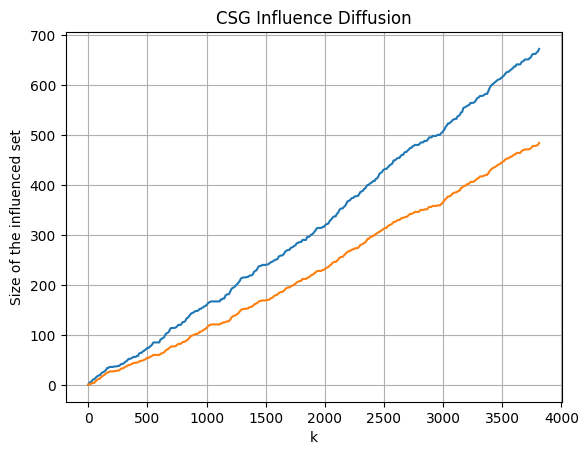

In [ ]:
plt.plot(ks, sizes, label="Cost Seeds Greedy")
plt.plot(ks, ss_sizes, label="Seeds set size")
plt.xlabel("k")
plt.ylabel("Size of the influenced set")
plt.title("CSG Influence Diffusion")
plt.grid()

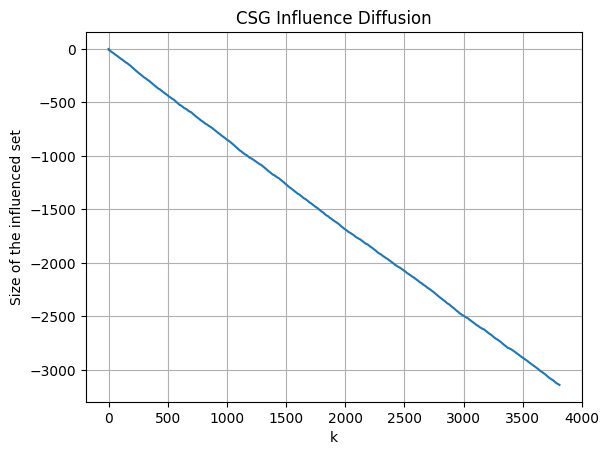

In [ ]:
plt.plot(ks, sizes - np.linspace(0, (G.number_of_nodes() + 1) // 2, 383), label="Cost Seeds Greedy")
plt.xlabel("k")
plt.ylabel("Size of the influenced set")
plt.title("CSG Influence Diffusion")
plt.grid()